In [60]:
#先導入資料處理會用到的模組
import os
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# 可視化模組
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機器學習模組
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn import preprocessing
from xgboost import XGBClassifier
import joblib
import pickle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',30)

In [61]:
rf_trained = False
svc_trained = False
xgb_trained = False

In [16]:
root_path = os.getcwd()
dataset = pd.read_csv(root_path+'/data/feature_sets/feature_selected.csv', index_col = 0)
X = dataset.drop('TmrDayoff', axis = 1)
y = dataset['TmrDayoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9896, 24)
(2474, 24)
(9896,)
(2474,)


In [17]:
dataset

,Dayoff,Precp,RH,StnHeight,StnPres,T.Max,T.Min,Temperature,TyWS,WDGust_vector_x,WDGust_vector_y,WD_vector_x,WD_vector_y,X10_radius,X7_radius,alert_num,born_spotE,born_spotN,hpa,lat,lon,route_--,route_2,route_3,TmrDayoff
0,1.0,0.430716,0.875000,1.000000,0.045045,0.092219,0.075000,0.179813,0.338983,0.220349,0.601709,0.385707,0.417754,0.833333,0.708333,0.441860,0.307263,0.485714,0.690722,0.360606,0.709591,0.0,0.0,1.0,0.0
1,1.0,0.285628,0.770833,0.342803,0.696782,0.484150,0.596429,0.482620,0.338983,0.251938,0.717161,0.330145,0.616334,0.833333,0.708333,0.441860,0.307263,0.485714,0.690722,0.438636,0.715604,0.0,0.0,1.0,0.0
2,1.0,0.196911,0.833333,0.033375,0.948520,0.654179,0.757143,0.675134,0.338983,0.253723,0.445569,0.483126,0.309033,0.833333,0.708333,0.441860,0.307263,0.485714,0.690722,0.497088,0.650266,0.0,0.0,1.0,0.0
3,1.0,0.390390,0.729167,0.012088,0.963449,0.694524,0.803571,0.731283,0.338983,0.235719,0.656661,0.572729,0.210564,0.833333,0.708333,0.441860,0.307263,0.485714,0.690722,0.522146,0.606633,0.0,0.0,1.0,0.0
4,1.0,0.018447,0.479167,0.010053,0.963707,0.706052,0.839286,0.779412,0.338983,0.617035,0.200414,0.605378,0.319429,0.833333,0.708333,0.441860,0.307263,0.485714,0.690722,0.721509,0.937114,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12365,1.0,0.212033,0.770833,0.199333,0.931789,0.616715,0.585714,0.622995,0.203390,0.640655,0.236343,0.532855,0.610608,0.666667,0.708333,0.093023,0.372439,0.251429,0.824742,0.389318,0.839472,1.0,0.0,0.0,1.0
12366,1.0,0.159560,0.859375,0.319203,0.830952,0.567363,0.645536,0.579880,0.203390,0.585069,0.501437,0.476883,0.496236,0.666667,0.708333,0.093023,0.372439,0.251429,0.824742,0.497371,0.884807,1.0,0.0,0.0,1.0
12367,0.0,0.128700,0.750000,0.005739,0.977606,0.674352,0.771429,0.711230,0.203390,0.753003,0.698558,0.612335,0.719717,0.666667,0.708333,0.093023,0.372439,0.251429,0.824742,0.458319,0.902575,1.0,0.0,0.0,1.0
12368,0.0,0.168168,0.930556,0.130650,0.892321,0.568684,0.698810,0.613636,0.203390,0.585818,0.744335,0.589097,0.694511,0.666667,0.708333,0.093023,0.372439,0.251429,0.824742,0.367166,0.875187,1.0,0.0,0.0,1.0


In [18]:
'''
hyper tuning for rf
'''

max_depth = [i for i in range(1, 101, 11)]
max_depth.append('None')

rf_distribution = {
    'n_estimators':[i for i in range(40, 500, 20)],
    'min_samples_leaf': [1,2,4],
    'max_depth': max_depth,
    'min_samples_split': [3,4,5,6,7,8]
}

def train_rf(X_train, y_train, n_iter):
    global rf_trained, rf_start, rf_end
    if not rf_trained:
        rf_start = time.time()
        rf = RandomForestClassifier(class_weight = 'balanced')
        RSCV_rf = RandomizedSearchCV(estimator = rf, 
                                     param_distributions = rf_distribution,
                                     cv=5,
                                     n_iter=n_iter,
                                     n_jobs = -1,
                                     verbose=1)
        RSCV_rf_fit = RSCV_rf.fit(X_train, y_train)
        rf_end = time.time()
        rf_trained = True
        print('rf search time: ', rf_end-rf_start)
    else:
        raise ValueError('Random forest model is already trained')
    return RSCV_rf_fit

RSCV_rf = train_rf(X_train, y_train, 100)
RSCV_rf.best_estimator_.score(X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/shyanechang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shyanechang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shyanechang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/shyanechang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/parallel.py", line 

rf search time:  609.703008890152


0.9324979789814066

In [59]:
model = joblib.load(root_path+'/data/models/rf_model.joblib')
model.predict_proba(pd.DataFrame(X_test.loc[10883,:]).T)[0][1]

0.002380952380952381

In [58]:
y_test

10883    0.0
510      1.0
4558     1.0
8001     1.0
1998     0.0
        ... 
2632     0.0
3082     1.0
910      0.0
7061     0.0
4705     1.0
Name: TmrDayoff, Length: 2474, dtype: float64

/Users/shyanechang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/shyanechang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


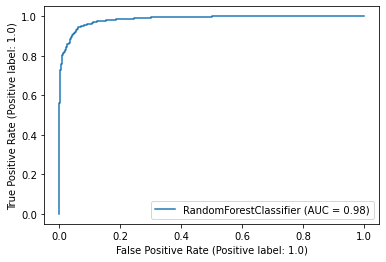

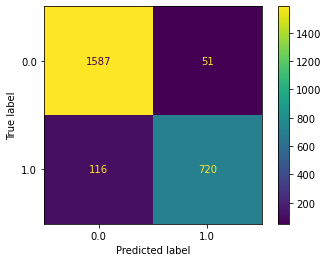

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix

plot_roc_curve(RSCV_rf.best_estimator_, X_test, y_test).figure_
# rf_ROC.savefig(root_path+'data/plots/rf_ROC.png')
plt.show

rf_CM = plot_confusion_matrix(RSCV_rf.best_estimator_, X_test, y_test)
# rf_CM.savefig(root_path+'data/plots/rf_CM.png')
plt.show()


In [49]:
# 存檔
joblib.dump(RSCV_rf.best_estimator_, root_path+'/data/models/rf_model.joblib')

['/Users/shyanechang/Desktop/AI_Class/專題/data/models/rf_model.joblib']

In [ ]:
# '''
# hyper tuning for xgb
# '''
# params = {
#     'objective': 'binary:logistic',
# #     'eval_metric': 'error',
#     'n_estimators': 500,
# #     'subsample': 0.1, 
# #     'max_depth': 7,
# #     'min_child_weight': 0.91,
# #     'gamma': 5,
# #     'reg_lamma': 0.1,
# #     'reg_alpha': 0.1,
# #     'eta': 0.871
# }

# xgb_distribution = {
# #     'n_estimators': [i for i in range(100, 1000, 100)],  # 300
#     'max_depth': np.linspace(1, 10, 10, dtype = 'int'), # 7
# #     'min_child_weight': np.linspace(0.1, 1, 11, dtype = 'float'), # 0.91
# #     'gamma': np.linspace(0, 0.1, 11),
# #     'subsample': np.linspace(0, 0.1, 11), 
# #     'reg_lambda': np.linspace(0, 1, 11, dtype = 'float'),
# #     'reg_alpha': np.linspace(0, 1, 11),
# #     'eta': np.linspace(0.87, 0.88, 11),
# }


# xgbc = XGBClassifier(**params)
# gs = GridSearchCV(xgbc, xgb_distribution, refit = True, n_jobs=-1, cv=5, verbose = 2)
# xgbc_model=gs.fit(X_train, y_train, sample_weight=weights)
# # pred_test = xgbc_model.predict_proba(X_test)

# # RSCV_xgb = train_xgb(X_train, y_train, 100)
# # RSCV_xgb_fit.best_estimator_.score(X_test, y_test)

In [128]:
RSCV_xgb.best_params_

{'subsample': 0.1,
 'reg_lambda': 0.8,
 'reg_alpha': 0.5,
 'n_estimators': 500,
 'min_child_weight': 7,
 'max_depth': 5,
 'gamma': 0.5,
 'eta': 0.1}

['/Users/shyanechang/Desktop/AI_Class/專題/data/models/rf.joblib']

In [115]:
a = joblib.load(root_path+'/data/models/rf.joblib')
a.score(X_test, y_test)

0.9251839738348324

[03:48:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 80/100] END eta=0.82, gamma=0.8, max_depth=5, min_child_weight=7, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0, subsample=0.04;, score=0.753 total time=   0.8s
[CV 3/5; 80/100] START eta=0.82, gamma=0.8, max_depth=5, min_child_weight=7, n_estimators=100, reg_alpha=1.0, reg_lambda=0.0, subsample=0.04
[03:48:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 80/100] END eta=0.82, gamma=0.8, max_depth=5

[CV 3/5; 74/100] END eta=0.73, gamma=0.2, max_depth=1, min_child_weight=1, n_estimators=800, reg_alpha=0.9, reg_lambda=0.8, subsample=0.03;, score=0.772 total time=   3.3s
[CV 2/5; 75/100] START eta=1.0, gamma=0.2, max_depth=5, min_child_weight=6, n_estimators=500, reg_alpha=0.1, reg_lambda=0.0, subsample=0.03
[03:48:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 75/100] END eta=1.0, gamma=0.2, max_depth=5, min_child_weight=6, n_estimators=500, reg_alpha=0.1, reg_lambda=0.0, subsample=0.03;, score=0.703 total time=   2.3s
[CV 4/5; 75/100] START eta=1.0, gamma=0.2, max_depth=5, min_child_weight=6, n_estimators=500, reg_alpha=0.1, reg_lambda=0.0, subsample=0.03
[03:48:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboo

[CV 1/5; 79/100] END eta=0.1, gamma=0.4, max_depth=10, min_child_weight=3, n_estimators=200, reg_alpha=0.5, reg_lambda=0.1, subsample=0.04;, score=0.848 total time=   3.3s
[CV 5/5; 79/100] START eta=0.1, gamma=0.4, max_depth=10, min_child_weight=3, n_estimators=200, reg_alpha=0.5, reg_lambda=0.1, subsample=0.04
[03:48:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 79/100] END eta=0.1, gamma=0.4, max_depth=10, min_child_weight=3, n_estimators=200, reg_alpha=0.5, reg_lambda=0.1, subsample=0.04;, score=0.853 total time=   3.0s
[CV 4/5; 81/100] START eta=0.1, gamma=0.1, max_depth=9, min_child_weight=4, n_estimators=800, reg_alpha=0.9, reg_lambda=0.6000000000000001, subsample=0.04
[03:48:49] WARNING: /Users/runner/miniforge